# Set-Up

In [1]:
import jax
import jax.numpy as jnp
import approx_post
import oed_toolbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.insert(0, '..')
import plotting_helpers
import computation_helpers
from arraytainers import Jaxtainer
sns.set({'figure.facecolor':'white'})

In [2]:
# dpi of images displayed in notebook:
mpl.rcParams['figure.dpi'] = 100
# dpi of images saved to seperate folder:
mpl_save_dpi = 300
# Plot theme:
sns.set_theme(style='darkgrid')

In [3]:
fig_save_dir = './figs/vi'
if not os.path.isdir(fig_save_dir):
    os.makedirs(fig_save_dir)

# Plotting Functions

In [4]:
palette = sns.color_palette()
samples_per_d = 100

In [5]:
def plot_data(y, d, model, theta_lims=(-5,5)):
    y_reshaped = y.reshape(-1, samples_per_d)
    d_reshaped = d.reshape(-1, samples_per_d)
    theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
    fig, ax = plt.subplots()
    for idx, (y_i, d_i) in enumerate(zip(y_reshaped, d_reshaped)):
        d_val = d_i[0]
        sns.scatterplot(x=theta.squeeze(), y=y_i.squeeze())
        sns.lineplot(x=theta.squeeze(), y=model(theta,d_val).squeeze(), label=f"d={d_val:.1f}", color=palette[idx])
        plt.xlabel("Parameter $\\theta$")
        plt.ylabel("Observations $y$")
    
    return fig

In [34]:
def plot_phi_function(amortised_dist, d_idx=None, d=None, y_obs=None, model=None, y_lims=(-50,50), num_y_pts=200, theta_lims=(-5,5)):
    y = jnp.linspace(y_lims[0], y_lims[1], num_y_pts).reshape(-1,1)
    if (d is None) and (d_idx is None):
        d_plot = 0.0
        pred_phi = amortised_dist.phi(y)
    else:
        d_plot = d.reshape(-1,samples_per_d)[d_idx,:][0]
        pred_phi = amortised_dist.phi(y, d_plot)
    pred_mean, pred_std = pred_phi['mean'].squeeze(), jnp.exp(pred_phi['log_chol_diag']).squeeze()
    mean_plus_cov = pred_mean + 2*pred_std
    mean_minus_cov = pred_mean - 2*pred_std
    
    x_plt = y.squeeze()
    ax = sns.lineplot(x=x_plt, y=pred_mean, label=f"Predicted Mean", color='red')
    sns.lineplot(x=x_plt, y=mean_plus_cov, color='red', linestyle='--')
    sns.lineplot(x=x_plt, y=mean_minus_cov, color='red', linestyle='--')
    ax.fill_between(x_plt, mean_minus_cov, mean_plus_cov, color="red", alpha=0.2)
    if y_obs is not None:
        y_plot = y_obs.reshape(-1,samples_per_d)[d_idx,:]
        true_theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
        sns.scatterplot(x=y_plot.squeeze(), y=true_theta.squeeze(), label=f"Observations") 
    if model is not None:
        true_theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
        sns.scatterplot(x=model(true_theta.squeeze(), d_plot), y=true_theta.squeeze(), label=f"True Relationship", color='g')
    plt.xlabel("Observation $y$")
    plt.ylabel("Parameter $\\theta$")

# Artificial Data Creation

In [8]:
def create_data(model, d_vals, noise_cov, prngkey, theta_lims=(-5,5)):
    theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
    # Zero-mean samples:
    epsilon = jax.random.multivariate_normal(prngkey, mean=jnp.zeros((1,)), 
                                             cov=noise_cov, shape=(samples_per_d,)) # shape = (num_batch, dim_x)
    y, d = [], []
    for d_i in d_vals:
        mean_vals = model(theta, d_i).reshape(samples_per_d, -1) # shape = (num_batch, dim_theta)
        y.append(mean_vals + epsilon) # shape = (num_batch, x_dim)
        d.append(jnp.repeat(d_i, repeats=samples_per_d).reshape(samples_per_d, -1))
    return jnp.concatenate(y, axis=0), jnp.concatenate(d, axis=0)

In [9]:
# Define model:
ndim = 1
# model_func = lambda theta, d: d*theta**2
def model_func(theta, d):
    y = d*theta**2
    return y

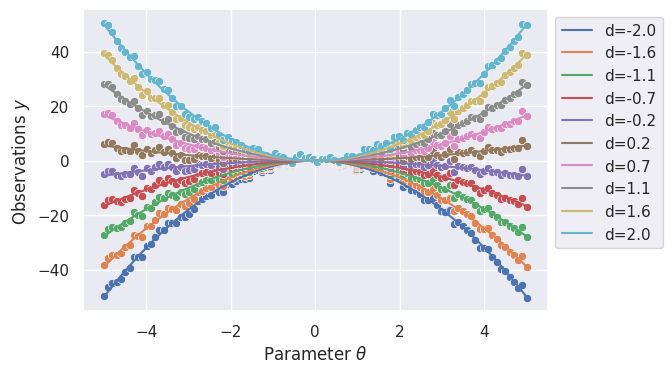

In [10]:
prngkey = jax.random.PRNGKey(42)
d_vals = jnp.linspace(-2, 2, 10) #, 1.5
noise_cov = jnp.identity(ndim)
y, d = create_data(model_func, d_vals, noise_cov, prngkey)
fig = plot_data(y, d, model_func)
fig.show()
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(fig_save_dir, 'amortised_data.png'), dpi=mpl_save_dpi, bbox_inches='tight')

In [11]:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
noise_cov = jnp.identity(ndim)

Now let's try include $d$:

In [23]:
model, model_grad = approx_post.models.from_jax(model_func)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)
prngkey = jax.random.PRNGKey(10)
approx_dist = approx_post.distributions.approx.Gaussian(1)
preprocessing = approx_post.distributions.amortised.Preprocessing.std_scaling(y, d) #,d
phi_lims = None 
reverse_approx = approx_post.distributions.amortised.NeuralNetwork(approx_dist, x_dim=1, d_dim=1, prngkey=prngkey, 
                                                                   num_layers=5, width=5, activation='tanh',
                                                                   preprocessing=preprocessing, phi_lims=phi_lims)

In [24]:
loss = approx_post.losses.ELBO(joint_dist, use_reparameterisation=True)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(reverse_approx, loss, x=y, d=d, prngkey=prngkey, verbose=True, num_samples=1000, max_iter=100) 

Loss = 93.38685607910156, Params = Jaxtainer({'W_0': DeviceArray([[ 0.60573757, -0.18924844,  1.135692  , -0.42174807,
              -1.4182752 ],
             [ 0.54226005, -0.23708427, -0.27424976,  0.83836293,
              -0.35252082]], dtype=float32), 'b_0': DeviceArray([ 0.1       ,  0.09999999, -0.09999999, -0.1       ,
              0.09999999], dtype=float32), 'W_1': DeviceArray([[-0.16566357, -0.56231135, -0.47581702, -0.31056714,
               0.5343586 ],
             [-0.29493076,  1.270614  , -1.3519593 ,  0.40102258,
              -0.00757471],
             [-0.5706646 ,  0.73799896,  0.21807295,  0.47774735,
              -0.23291188],
             [-0.12278592,  0.9858867 ,  0.6705841 , -0.5291183 ,
              -0.8476602 ],
             [-1.1499256 ,  0.89719653,  0.9151989 ,  0.47091696,
               1.0498979 ]], dtype=float32), 'b_1': DeviceArray([ 0.1       , -0.09999999,  0.1       ,  0.1       ,
             -0.10000001], dtype=float32), 'W_2': DeviceArray

Loss = 79.6031494140625, Params = Jaxtainer({'W_0': DeviceArray([[ 0.47501385, -0.2176777 ,  1.0017027 , -0.19270346,
              -1.3529822 ],
             [ 0.4404746 , -0.5206513 , -0.51237863,  0.95416135,
              -0.55260736]], dtype=float32), 'b_0': DeviceArray([ 0.3395935 ,  0.06238328, -0.15453379, -0.3146871 ,
              0.14979327], dtype=float32), 'W_1': DeviceArray([[-0.15067315, -0.65285987, -0.32841337, -0.12792328,
               0.67626417],
             [-0.3008716 ,  1.3258734 , -1.4969633 ,  0.21731699,
              -0.14987567],
             [-0.56239444,  0.78613275,  0.3638058 ,  0.6627344 ,
              -0.09333637],
             [ 0.01132528,  0.8073617 ,  0.54761684, -0.716591  ,
              -1.1040688 ],
             [-1.1704004 ,  0.84182894,  0.76247627,  0.28579265,
               0.92410505]], dtype=float32), 'b_1': DeviceArray([ 0.06076403, -0.29731855,  0.19421417,  0.29407024,
             -0.08998343], dtype=float32), 'W_2': DeviceArray(

Loss = 47.591712951660156, Params = Jaxtainer({'W_0': DeviceArray([[ 0.21734768,  0.0085288 ,  1.1311417 , -0.11892869,
              -1.1019186 ],
             [ 0.5189909 , -0.788899  , -0.73099816,  1.0855316 ,
              -0.81369424]], dtype=float32), 'b_0': DeviceArray([ 0.29504225,  0.29076087, -0.04977148, -0.2005315 ,
              0.3711294 ], dtype=float32), 'W_1': DeviceArray([[-0.05108777, -0.50367814, -0.29222533, -0.02880958,
               0.7426782 ],
             [-0.42384672,  1.4826903 , -1.5276089 ,  0.10724869,
              -0.24541147],
             [-0.50289637,  1.0234789 ,  0.4035963 ,  0.77205914,
              -0.00243812],
             [ 0.09369723,  0.5766772 ,  0.5296117 , -0.8621749 ,
              -1.3445104 ],
             [-1.2675006 ,  0.63335145,  0.7242561 ,  0.18559738,
               0.85760885]], dtype=float32), 'b_1': DeviceArray([-0.08374381, -0.16301483,  0.31452787,  0.3128707 ,
             -0.0745592 ], dtype=float32), 'W_2': DeviceArra

Loss = 47.42351531982422, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1924968 ,  0.01675767,  1.1334625 , -0.107082  ,
              -0.8766173 ],
             [ 0.5297056 , -0.814077  , -0.81652814,  1.1361315 ,
              -1.014367  ]], dtype=float32), 'b_0': DeviceArray([ 2.2060135e-01,  2.0799415e-01,  6.8385620e-05,
             -2.1499242e-01,  5.7953328e-01], dtype=float32), 'W_1': DeviceArray([[ 1.7180175e-02, -5.2712953e-01, -4.5294240e-01,
              -1.4455089e-01,  7.2735357e-01],
             [-3.8800654e-01,  1.5097228e+00, -1.3773584e+00,
               2.1141373e-01, -1.8975590e-01],
             [-4.4335806e-01,  1.0047122e+00,  2.4072197e-01,
               6.5773851e-01,  1.7131772e-04],
             [ 2.6950052e-01,  4.7444573e-01,  5.5291563e-01,
              -9.4436848e-01, -1.5028245e+00],
             [-1.3396133e+00,  6.5486413e-01,  8.8557118e-01,
               3.0230621e-01,  8.6395556e-01]], dtype=float32), 'b_1': DeviceArray([-0.02179286, -0.1749232

Loss = 46.56539535522461, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2346344 , -0.030117  ,  1.0727615 , -0.13247775,
              -0.6838949 ],
             [ 0.5617927 , -0.8892215 , -0.9098213 ,  1.1501442 ,
              -1.1584022 ]], dtype=float32), 'b_0': DeviceArray([ 0.13251923,  0.12344074,  0.03935032, -0.10582073,
              0.78501576], dtype=float32), 'W_1': DeviceArray([[ 0.11311258, -0.61355305, -0.58611333, -0.23124264,
               0.7381434 ],
             [-0.333259  ,  1.5835258 , -1.2555623 ,  0.28455853,
              -0.1545162 ],
             [-0.34521195,  0.9171631 ,  0.1055319 ,  0.57246923,
               0.03124824],
             [ 0.41728842,  0.37145823,  0.52719957, -1.059638  ,
              -1.6316335 ],
             [-1.4408616 ,  0.74322915,  1.0214795 ,  0.39048088,
               0.84078217]], dtype=float32), 'b_1': DeviceArray([ 0.07703562, -0.26466936,  0.35040754,  0.26882362,
             -0.14214118], dtype=float32), 'W_2': DeviceArray

Loss = 34.48340606689453, Params = Jaxtainer({'W_0': DeviceArray([[ 0.25955763, -0.06399818,  1.0353613 , -0.17130148,
              -0.5181061 ],
             [ 0.58134294, -0.94353056, -0.97827524,  1.1441478 ,
              -1.265908  ]], dtype=float32), 'b_0': DeviceArray([0.04138891, 0.06544493, 0.0921104 , 0.03756027, 0.97489214],            dtype=float32), 'W_1': DeviceArray([[ 0.1799656 , -0.676542  , -0.68384063, -0.28216437,
               0.75705236],
             [-0.27334923,  1.6379967 , -1.1653723 ,  0.32289267,
              -0.15138222],
             [-0.27612326,  0.8535052 ,  0.00857515,  0.5225537 ,
               0.06542628],
             [ 0.5332145 ,  0.29577363,  0.5071446 , -1.1554215 ,
              -1.7332807 ],
             [-1.5132903 ,  0.8084678 ,  1.1221138 ,  0.4427616 ,
               0.81171554]], dtype=float32), 'b_1': DeviceArray([ 0.1516297 , -0.3285269 ,  0.34216106,  0.1893116 ,
             -0.2311197 ], dtype=float32), 'W_2': DeviceArray([[ 0.1

Loss = 29.649324417114258, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2683361 , -0.08935396,  1.0068992 , -0.18487087,
              -0.42784745],
             [ 0.5969169 , -0.98449165, -1.031065  ,  1.1578716 ,
              -1.3472283 ]], dtype=float32), 'b_0': DeviceArray([-0.00348588,  0.02004794,  0.13020992,  0.11358881,
              1.1174839 ], dtype=float32), 'W_1': DeviceArray([[ 0.23179732, -0.72346157, -0.7568223 , -0.33148605,
               0.7549409 ],
             [-0.23988739,  1.6789253 , -1.0977137 ,  0.36416528,
              -0.12292433],
             [-0.22269282,  0.80651116, -0.06366068,  0.47306615,
               0.07225797],
             [ 0.6187232 ,  0.23827557,  0.49355567, -1.2145543 ,
              -1.7866702 ],
             [-1.5690868 ,  0.8562215 ,  1.1970937 ,  0.49472183,
               0.8100923 ]], dtype=float32), 'b_1': DeviceArray([ 0.20654161, -0.37708002,  0.33520508,  0.13592486,
             -0.2816412 ], dtype=float32), 'W_2': DeviceArra

Loss = 23.923267364501953, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2634535 , -0.10881509,  0.97505116, -0.15746151,
              -0.45739794],
             [ 0.6092379 , -1.0166693 , -1.0789988 ,  1.2168045 ,
              -1.4159659 ]], dtype=float32), 'b_0': DeviceArray([ 0.02026497, -0.02134011,  0.1338612 ,  0.06665446,
              1.168913  ], dtype=float32), 'W_1': DeviceArray([[ 0.2762656 , -0.75912404, -0.81128347, -0.3942117 ,
               0.7109237 ],
             [-0.24675554,  1.7117288 , -1.0475531 ,  0.4242259 ,
              -0.03413568],
             [-0.17687544,  0.77093136, -0.11922587,  0.4092606 ,
               0.03232323],
             [ 0.6850403 ,  0.19251297,  0.48498386, -1.2409766 ,
              -1.7945042 ],
             [-1.6141605 ,  0.889958  ,  1.2524016 ,  0.56183076,
               0.85724455]], dtype=float32), 'b_1': DeviceArray([ 0.2471827 , -0.4168775 ,  0.3280645 ,  0.12205467,
             -0.25537032], dtype=float32), 'W_2': DeviceArra

Loss = 21.490684509277344, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2533399 , -0.12312033,  0.95000935, -0.15141807,
              -0.5246352 ],
             [ 0.62062955, -1.0420754 , -1.1246219 ,  1.2480212 ,
              -1.4722906 ]], dtype=float32), 'b_0': DeviceArray([ 0.07181282, -0.06025815,  0.10325357,  0.00192658,
              1.1477034 ], dtype=float32), 'W_1': DeviceArray([[ 3.1176147e-01, -7.8625673e-01, -8.5234636e-01,
              -4.3876621e-01,  6.9734174e-01],
             [-2.6560089e-01,  1.7388839e+00, -1.0101699e+00,
               4.6613413e-01, -1.7004323e-03],
             [-1.4124258e-01,  7.4499679e-01, -1.6446871e-01,
               3.6282748e-01,  1.9987324e-02],
             [ 7.3723280e-01,  1.5546647e-01,  4.8211253e-01,
              -1.2623522e+00, -1.8172476e+00],
             [-1.6469498e+00,  9.1329253e-01,  1.2938670e+00,
               6.1022544e-01,  8.7484956e-01]], dtype=float32), 'b_1': DeviceArray([ 0.2783466 , -0.44977653,  0.32243717

Loss = 22.070072174072266, Params = Jaxtainer({'W_0': DeviceArray([[ 0.23202787, -0.13313279,  0.9253997 , -0.15636967,
              -0.60742676],
             [ 0.5966072 , -1.0628434 , -1.1771655 ,  1.2611067 ,
              -1.4984777 ]], dtype=float32), 'b_0': DeviceArray([ 0.11878366, -0.09620854,  0.05648199, -0.00280102,
              1.0880207 ], dtype=float32), 'W_1': DeviceArray([[ 0.34089482, -0.8062793 , -0.87029016, -0.4902789 ,
               0.70194745],
             [-0.29657248,  1.7591097 , -1.0040474 ,  0.51925904,
              -0.00196245],
             [-0.11335766,  0.7272616 , -0.20642892,  0.3088768 ,
               0.02505028],
             [ 0.76791155,  0.12632343,  0.5034998 , -1.2268798 ,
              -1.8361611 ],
             [-1.6713443 ,  0.9292378 ,  1.3112836 ,  0.6627881 ,
               0.8709058 ]], dtype=float32), 'b_1': DeviceArray([ 0.30593294, -0.47617313,  0.3248343 ,  0.13298538,
             -0.22123867], dtype=float32), 'W_2': DeviceArra

Loss = 21.388336181640625, Params = Jaxtainer({'W_0': DeviceArray([[ 0.21150182, -0.13996415,  0.90032476, -0.18675183,
              -0.6540756 ],
             [ 0.5458418 , -1.0796936 , -1.2309835 ,  1.2502692 ,
              -1.5160898 ]], dtype=float32), 'b_0': DeviceArray([ 1.6803545e-01, -1.2598000e-01,  5.4249167e-03,
             -8.5044699e-04,  1.0138175e+00], dtype=float32), 'W_1': DeviceArray([[ 0.3503489 , -0.82105565, -0.87714994, -0.4435256 ,
               0.75396335],
             [-0.25409994,  1.7736329 , -1.0121576 ,  0.46400103,
              -0.07549721],
             [-0.10579538,  0.7146496 , -0.2497634 ,  0.35446182,
               0.0802994 ],
             [ 0.8544225 ,  0.10395148,  0.5377525 , -1.3226182 ,
              -1.9362684 ],
             [-1.675989  ,  0.9403257 ,  1.3156943 ,  0.6160179 ,
               0.81798345]], dtype=float32), 'b_1': DeviceArray([ 0.32730317, -0.49712908,  0.32207403,  0.19131741,
             -0.2024549 ], dtype=float32), 'W

Loss = 17.438329696655273, Params = Jaxtainer({'W_0': DeviceArray([[ 0.19884147, -0.14526251,  0.8762738 , -0.16580492,
              -0.69702   ],
             [ 0.5048385 , -1.092626  , -1.2778779 ,  1.281227  ,
              -1.5351102 ]], dtype=float32), 'b_0': DeviceArray([ 0.1942123 , -0.14904523, -0.04324925,  0.06819481,
              0.9290839 ], dtype=float32), 'W_1': DeviceArray([[ 0.36582556, -0.83222604, -0.88334006, -0.45918185,
               0.7712299 ],
             [-0.26520243,  1.7846322 , -1.016987  ,  0.47823176,
              -0.09705091],
             [-0.09215879,  0.7050021 , -0.28649566,  0.3386444 ,
               0.10139529],
             [ 0.88967264,  0.08725502,  0.5640558 , -1.3412678 ,
              -1.9652728 ],
             [-1.6870335 ,  0.9489634 ,  1.3199874 ,  0.6302285 ,
               0.7972327 ]], dtype=float32), 'b_1': DeviceArray([ 0.34300232, -0.5126628 ,  0.31904128,  0.19554459,
             -0.23880701], dtype=float32), 'W_2': DeviceArra

Loss = 16.660694122314453, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18021332, -0.14896291,  0.84410733, -0.16154452,
              -0.7058077 ],
             [ 0.46242756, -1.1025184 , -1.3266649 ,  1.2940614 ,
              -1.5493096 ]], dtype=float32), 'b_0': DeviceArray([ 0.20012361, -0.16605945, -0.08819414,  0.157955  ,
              0.8799968 ], dtype=float32), 'W_1': DeviceArray([[ 0.3722373 , -0.84047973, -0.88579476, -0.463435  ,
               0.7928071 ],
             [-0.24732947,  1.7924197 , -1.0247467 ,  0.48072627,
              -0.12596807],
             [-0.08721382,  0.69786596, -0.31810093,  0.3349502 ,
               0.12684628],
             [ 0.93111897,  0.07460635,  0.59043914, -1.360769  ,
              -2.0007038 ],
             [-1.6906006 ,  0.9557298 ,  1.3205668 ,  0.6327387 ,
               0.7722998 ]], dtype=float32), 'b_1': DeviceArray([ 0.3595462 , -0.52393353,  0.31989315,  0.17012547,
             -0.2828615 ], dtype=float32), 'W_2': DeviceArra

Loss = 15.588626861572266, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15351737, -0.1518497 ,  0.78976184, -0.14210808,
              -0.66075844],
             [ 0.4109411 , -1.1106635 , -1.3882241 ,  1.3187214 ,
              -1.5597732 ]], dtype=float32), 'b_0': DeviceArray([ 0.1778868 , -0.17711954, -0.1360243 ,  0.20190056,
              0.88022935], dtype=float32), 'W_1': DeviceArray([[ 0.38246024, -0.8465597 , -0.8788937 , -0.47879395,
               0.80553615],
             [-0.26165423,  1.7981687 , -1.045209  ,  0.49602506,
              -0.14193143],
             [-0.078237  ,  0.69279104, -0.34207636,  0.31974775,
               0.1422203 ],
             [ 0.9435336 ,  0.0650813 ,  0.6252485 , -1.3637819 ,
              -2.0308845 ],
             [-1.6995951 ,  0.9612668 ,  1.3113943 ,  0.6470719 ,
               0.75758374]], dtype=float32), 'b_1': DeviceArray([ 0.365583  , -0.5314786 ,  0.32998428,  0.16853073,
             -0.30669132], dtype=float32), 'W_2': DeviceArra

Loss = 13.841513633728027, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12470166, -0.1540378 ,  0.73923063, -0.13160259,
              -0.58153623],
             [ 0.35746643, -1.1173017 , -1.4412184 ,  1.3313967 ,
              -1.5694114 ]], dtype=float32), 'b_0': DeviceArray([ 0.1464879 , -0.18360412, -0.17370549,  0.24118645,
              0.9108991 ], dtype=float32), 'W_1': DeviceArray([[ 0.39417136, -0.85108864, -0.88242865, -0.49967596,
               0.82625234],
             [-0.29232195,  1.8025825 , -1.0494838 ,  0.5175707 ,
              -0.17048427],
             [-0.0677645 ,  0.6891913 , -0.3716264 ,  0.29899025,
               0.16486238],
             [ 0.93078643,  0.05788442,  0.64473957, -1.3510716 ,
              -2.060817  ],
             [-1.7110788 ,  0.9658768 ,  1.3117416 ,  0.66716754,
               0.7357584 ]], dtype=float32), 'b_1': DeviceArray([ 0.365475  , -0.5363888 ,  0.32953924,  0.17716731,
             -0.32979888], dtype=float32), 'W_2': DeviceArra

Loss = 12.250527381896973, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13371387, -0.15592824,  0.69908744, -0.12455872,
              -0.49519482],
             [ 0.31726086, -1.1227922 , -1.4812241 ,  1.3300788 ,
              -1.5757774 ]], dtype=float32), 'b_0': DeviceArray([ 0.11062306, -0.18748909, -0.20142739,  0.32668704,
              0.9512154 ], dtype=float32), 'W_1': DeviceArray([[ 0.40772432, -0.85451245, -0.89150417, -0.53063726,
               0.8594857 ],
             [-0.33792466,  1.8060154 , -1.0447521 ,  0.55042344,
              -0.2184943 ],
             [-0.0550943 ,  0.68649405, -0.4018723 ,  0.26772845,
               0.19919895],
             [ 0.89664656,  0.0526457 ,  0.64971083, -1.3213563 ,
              -2.0852554 ],
             [-1.7249812 ,  0.9696369 ,  1.3172952 ,  0.6978842 ,
               0.70244336]], dtype=float32), 'b_1': DeviceArray([ 0.3612111 , -0.53957915,  0.3221816 ,  0.18609618,
             -0.39199373], dtype=float32), 'W_2': DeviceArra

Loss = 11.656476020812988, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14585617, -0.15774179,  0.6607898 , -0.11210097,
              -0.40099123],
             [ 0.27534196, -1.1276555 , -1.5105592 ,  1.3266358 ,
              -1.5818864 ]], dtype=float32), 'b_0': DeviceArray([ 0.08203696, -0.18779837, -0.21065848,  0.42385575,
              1.000817  ], dtype=float32), 'W_1': DeviceArray([[ 0.41423154, -0.8569268 , -0.8982635 , -0.5539555 ,
               0.8925303 ],
             [-0.355266  ,  1.8080088 , -1.0433416 ,  0.5755558 ,
              -0.2655151 ],
             [-0.04860985,  0.6847106 , -0.4250362 ,  0.24255313,
               0.23008527],
             [ 0.8934772 ,  0.04867718,  0.6526491 , -1.3053786 ,
              -2.1033418 ],
             [-1.733146  ,  0.972656  ,  1.3199857 ,  0.72287375,
               0.6727983 ]], dtype=float32), 'b_1': DeviceArray([ 0.36051765, -0.5414991 ,  0.31384572,  0.17647876,
             -0.46854904], dtype=float32), 'W_2': DeviceArra

Loss = 11.907571792602539, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13844875, -0.15947695,  0.59361845, -0.1099485 ,
              -0.30827487],
             [ 0.21471164, -1.1321747 , -1.5478264 ,  1.3209032 ,
              -1.590711  ]], dtype=float32), 'b_0': DeviceArray([ 0.07336946, -0.18418053, -0.19747658,  0.46314758,
              1.0636436 ], dtype=float32), 'W_1': DeviceArray([[ 0.41070616, -0.85847396, -0.89343286, -0.55340165,
               0.92328   ],
             [-0.33089575,  1.8084952 , -1.0573244 ,  0.57552433,
              -0.306939  ],
             [-0.05105243,  0.68375844, -0.43380255,  0.23939653,
               0.2549793 ],
             [ 0.94107074,  0.04576109,  0.67093825, -1.3235015 ,
              -2.120171  ],
             [-1.7333878 ,  0.9750846 ,  1.3105453 ,  0.7270224 ,
               0.65198135]], dtype=float32), 'b_1': DeviceArray([ 0.36426532, -0.54246974,  0.31345615,  0.16107416,
             -0.5108031 ], dtype=float32), 'W_2': DeviceArra

Loss = 11.482233047485352, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1351916 , -0.16124551,  0.55997384, -0.10894299,
              -0.27369535],
             [ 0.14950967, -1.1363249 , -1.56137   ,  1.3163122 ,
              -1.6046927 ]], dtype=float32), 'b_0': DeviceArray([ 0.09846172, -0.1764748 , -0.13437718,  0.46990958,
              1.1270279 ], dtype=float32), 'W_1': DeviceArray([[ 0.39304122, -0.85944545, -0.88644826, -0.5325428 ,
               0.95152223],
             [-0.2511501 ,  1.8081465 , -1.0729637 ,  0.55429745,
              -0.34234133],
             [-0.06611848,  0.68311065, -0.43727535,  0.25487134,
               0.2753996 ],
             [ 1.0477189 ,  0.04365616,  0.6896751 , -1.3698736 ,
              -2.1299078 ],
             [-1.7219085 ,  0.97707593,  1.2988238 ,  0.71416384,
               0.6398794 ]], dtype=float32), 'b_1': DeviceArray([ 0.37778804, -0.5428945 ,  0.31198007,  0.12090835,
             -0.53336114], dtype=float32), 'W_2': DeviceArra

Loss = 11.039213180541992, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1680372 , -0.16328724,  0.5434184 , -0.10446557,
              -0.30082184],
             [ 0.10636337, -1.1401743 , -1.557372  ,  1.3127013 ,
              -1.6230507 ]], dtype=float32), 'b_0': DeviceArray([ 0.132956  , -0.16508225, -0.0289944 ,  0.4511164 ,
              1.1903241 ], dtype=float32), 'W_1': DeviceArray([[ 0.38102266, -0.86025935, -0.88104314, -0.5228032 ,
               0.9872507 ],
             [-0.21077947,  1.808363  , -1.0846351 ,  0.5466796 ,
              -0.3866404 ],
             [-0.07391435,  0.68228024, -0.43831387,  0.25737092,
               0.30179015],
             [ 1.125523  ,  0.04260974,  0.7032237 , -1.402155  ,
              -2.1157496 ],
             [-1.7186925 ,  0.9791156 ,  1.2893975 ,  0.7160613 ,
               0.62579703]], dtype=float32), 'b_1': DeviceArray([ 0.3842586 , -0.54257613,  0.30921483,  0.09161165,
             -0.5549062 ], dtype=float32), 'W_2': DeviceArra

Loss = 10.540998458862305, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2155053 , -0.16556336,  0.52740234, -0.10773947,
              -0.3366678 ],
             [ 0.08393259, -1.1436849 , -1.5416418 ,  1.2929863 ,
              -1.640253  ]], dtype=float32), 'b_0': DeviceArray([ 0.14680116, -0.15168113,  0.10126498,  0.44118613,
              1.2557932 ], dtype=float32), 'W_1': DeviceArray([[ 0.37689695, -0.86102605, -0.8835321 , -0.5269524 ,
               1.0443866 ],
             [-0.20150219,  1.8092238 , -1.0852484 ,  0.55464685,
              -0.46217024],
             [-0.07325771,  0.6812972 , -0.4418269 ,  0.24552825,
               0.350122  ],
             [ 1.1637493 ,  0.04244057,  0.7049139 , -1.4118719 ,
              -2.0696125 ],
             [-1.7248963 ,  0.9812627 ,  1.2884591 ,  0.73373914,
               0.5916281 ]], dtype=float32), 'b_1': DeviceArray([ 0.3832864 , -0.5416291 ,  0.30286413,  0.07416977,
             -0.59478325], dtype=float32), 'W_2': DeviceArra

Loss = 10.281188011169434, Params = Jaxtainer({'W_0': DeviceArray([[ 0.24697752, -0.16777235,  0.51233464, -0.10454869,
              -0.3454054 ],
             [ 0.06723917, -1.1465821 , -1.5165482 ,  1.2828188 ,
              -1.6528155 ]], dtype=float32), 'b_0': DeviceArray([ 0.15138142, -0.13941245,  0.24621312,  0.42090863,
              1.3241377 ], dtype=float32), 'W_1': DeviceArray([[ 0.36553243, -0.86147654, -0.88233864, -0.52350396,
               1.0952874 ],
             [-0.1702719 ,  1.8092724 , -1.0895412 ,  0.55437183,
              -0.5274837 ],
             [-0.08016113,  0.68057764, -0.43689975,  0.24235004,
               0.3940744 ],
             [ 1.2250347 ,  0.04252686,  0.7072634 , -1.4304761 ,
              -2.0168757 ],
             [-1.7243788 ,  0.9830154 ,  1.2850934 ,  0.7439676 ,
               0.5639745 ]], dtype=float32), 'b_1': DeviceArray([ 0.38787544, -0.54059577,  0.3024362 ,  0.05001593,
             -0.63548017], dtype=float32), 'W_2': DeviceArra

Loss = 9.23422908782959, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2525183 , -0.16972972,  0.50879073, -0.10399356,
              -0.3195632 ],
             [ 0.0424006 , -1.1488861 , -1.4710422 ,  1.2822104 ,
              -1.6597164 ]], dtype=float32), 'b_0': DeviceArray([ 0.15900724, -0.12918429,  0.39020425,  0.38760528,
              1.3941092 ], dtype=float32), 'W_1': DeviceArray([[ 0.34424454, -0.8615868 , -0.8745339 , -0.5052733 ,
               1.1225506 ],
             [-0.1090434 ,  1.8082186 , -1.1019514 ,  0.537844  ,
              -0.5573079 ],
             [-0.0978456 ,  0.680212  , -0.42326856,  0.25557727,
               0.41432363],
             [ 1.3132049 ,  0.04280584,  0.71541035, -1.4647251 ,
              -1.9981254 ],
             [-1.7138338 ,  0.98429734,  1.2758695 ,  0.7386449 ,
               0.5591992 ]], dtype=float32), 'b_1': DeviceArray([ 0.39936474, -0.5396323 ,  0.30946165,  0.02213465,
             -0.66169804], dtype=float32), 'W_2': DeviceArray(

Loss = 8.796211242675781, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2501775 , -0.17147624,  0.5482945 , -0.09447032,
              -0.26441932],
             [ 0.01826354, -1.1509022 , -1.3948485 ,  1.2862508 ,
              -1.6619084 ]], dtype=float32), 'b_0': DeviceArray([ 0.16398436, -0.1201188 ,  0.529935  ,  0.34669507,
              1.4633715 ], dtype=float32), 'W_1': DeviceArray([[ 0.3354311 , -0.8617068 , -0.88058496, -0.49903375,
               1.1512252 ],
             [-0.08686247,  1.8074328 , -1.0976721 ,  0.5338963 ,
              -0.5898046 ],
             [-0.10434824,  0.67993325, -0.4225449 ,  0.2582825 ,
               0.434364  ],
             [ 1.3515391 ,  0.04350998,  0.7067658 , -1.4800228 ,
              -1.9648173 ],
             [-1.7152119 ,  0.9855033 ,  1.2801193 ,  0.744287  ,
               0.55035406]], dtype=float32), 'b_1': DeviceArray([ 0.40049717, -0.53854614,  0.30463305,  0.00918691,
             -0.6744894 ], dtype=float32), 'W_2': DeviceArray

Loss = 8.390340805053711, Params = Jaxtainer({'W_0': DeviceArray([[ 0.20623207, -0.17284524,  0.46730378, -0.09154163,
              -0.19210826],
             [-0.02818618, -1.152505  , -1.3869528 ,  1.2883825 ,
              -1.6607761 ]], dtype=float32), 'b_0': DeviceArray([ 0.18019873, -0.11460228,  0.6834867 ,  0.29384962,
              1.5242571 ], dtype=float32), 'W_1': DeviceArray([[ 0.3339093 , -0.8616434 , -0.8858541 , -0.49725145,
               1.1698912 ],
             [-0.087429  ,  1.8065362 , -1.0941042 ,  0.5345775 ,
              -0.6057721 ],
             [-0.10457679,  0.6800079 , -0.42098692,  0.25757512,
               0.4507343 ],
             [ 1.3598552 ,  0.04404911,  0.69947827, -1.4861654 ,
              -1.9546242 ],
             [-1.7226156 ,  0.98626435,  1.2849373 ,  0.75301087,
               0.55045193]], dtype=float32), 'b_1': DeviceArray([ 0.39485916, -0.53768814,  0.3023666 ,  0.00997223,
             -0.6661932 ], dtype=float32), 'W_2': DeviceArray

Loss = 8.498637199401855, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14546885, -0.1733313 ,  0.4116797 , -0.08052276,
              -0.26118213],
             [-0.05030489, -1.1542633 , -1.3673447 ,  1.2950495 ,
              -1.6734722 ]], dtype=float32), 'b_0': DeviceArray([ 0.21479489, -0.11769732,  0.7979164 ,  0.269893  ,
              1.5128314 ], dtype=float32), 'W_1': DeviceArray([[ 0.33529007, -0.86121404, -0.890442  , -0.49980116,
               1.1801066 ],
             [-0.09946727,  1.8059858 , -1.0898938 ,  0.5400665 ,
              -0.6096755 ],
             [-0.10235021,  0.6806017 , -0.4171222 ,  0.25305778,
               0.45586917],
             [ 1.364855  ,  0.04175652,  0.6895148 , -1.4882646 ,
              -1.943269  ],
             [-1.7276171 ,  0.985064  ,  1.2918394 ,  0.762783  ,
               0.5533554 ]], dtype=float32), 'b_1': DeviceArray([ 0.39321232, -0.53872985,  0.30291307,  0.0076964 ,
             -0.6703477 ], dtype=float32), 'W_2': DeviceArray

Loss = 8.122695922851562, Params = Jaxtainer({'W_0': DeviceArray([[ 0.09411691, -0.17270331,  0.5016919 , -0.07773972,
              -0.26375914],
             [-0.02061303, -1.1568301 , -1.2868211 ,  1.2977954 ,
              -1.6931497 ]], dtype=float32), 'b_0': DeviceArray([ 0.24633487, -0.13291305,  0.8197005 ,  0.24208547,
              1.4685038 ], dtype=float32), 'W_1': DeviceArray([[ 0.33683664, -0.86100584, -0.8931348 , -0.50164986,
               1.1963462 ],
             [-0.11595351,  1.8079437 , -1.0873232 ,  0.54544103,
              -0.62395704],
             [-0.09998716,  0.6809277 , -0.40943396,  0.24951665,
               0.460666  ],
             [ 1.3835117 ,  0.03463876,  0.68178314, -1.4916598 ,
              -1.9140416 ],
             [-1.7280349 ,  0.98051804,  1.2969642 ,  0.77135783,
               0.5489347 ]], dtype=float32), 'b_1': DeviceArray([ 0.39531046, -0.5433924 ,  0.3084681 ,  0.00795136,
             -0.6785222 ], dtype=float32), 'W_2': DeviceArray

Loss = 10.112398147583008, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13658428, -0.17179303,  0.57914054, -0.09470637,
              -0.23374893],
             [ 0.04578619, -1.1592484 , -1.218811  ,  1.2893217 ,
              -1.7093464 ]], dtype=float32), 'b_0': DeviceArray([ 0.27360237, -0.14919426,  0.823155  ,  0.22488725,
              1.4283854 ], dtype=float32), 'W_1': DeviceArray([[ 0.33362356, -0.8609238 , -0.8985312 , -0.5001851 ,
               1.2171263 ],
             [-0.11979553,  1.8098675 , -1.0794564 ,  0.54790413,
              -0.6453516 ],
             [-0.10198514,  0.68123   , -0.40731278,  0.24875775,
               0.47182918],
             [ 1.411005  ,  0.02742687,  0.6702603 , -1.4974011 ,
              -1.8706602 ],
             [-1.7238894 ,  0.9757894 ,  1.3061265 ,  0.7766674 ,
               0.53831095]], dtype=float32), 'b_1': DeviceArray([ 0.40148553, -0.54818803,  0.31112027,  0.00350882,
             -0.69028145], dtype=float32), 'W_2': DeviceArra

Loss = 8.648475646972656, Params = Jaxtainer({'W_0': DeviceArray([[ 0.11473027, -0.17084298,  0.61612767, -0.10181671,
              -0.27396065],
             [ 0.0651296 , -1.1611096 , -1.1589057 ,  1.3004429 ,
              -1.7279365 ]], dtype=float32), 'b_0': DeviceArray([ 0.33268002, -0.16263776,  0.845548  ,  0.21924256,
              1.3813689 ], dtype=float32), 'W_1': DeviceArray([[ 0.32881707, -0.86062753, -0.90883553, -0.50018847,
               1.2113371 ],
             [-0.11984968,  1.809941  , -1.0663103 ,  0.5525513 ,
              -0.62564915],
             [-0.1048219 ,  0.6818216 , -0.41136512,  0.24558   ,
               0.45289367],
             [ 1.4437656 ,  0.02200041,  0.6501962 , -1.5044    ,
              -1.8518698 ],
             [-1.7196147 ,  0.97192246,  1.3203582 ,  0.7828315 ,
               0.55541676]], dtype=float32), 'b_1': DeviceArray([ 0.4095581 , -0.5518294 ,  0.30683112, -0.00826499,
             -0.6802339 ], dtype=float32), 'W_2': DeviceArray

Loss = 9.765979766845703, Params = Jaxtainer({'W_0': DeviceArray([[ 0.10698285, -0.17015764,  0.6301959 , -0.1044914 ,
              -0.27548096],
             [ 0.07391025, -1.1626364 , -1.1124747 ,  1.3138305 ,
              -1.7379098 ]], dtype=float32), 'b_0': DeviceArray([ 0.36174932, -0.17256187,  0.87017876,  0.19592005,
              1.3601637 ], dtype=float32), 'W_1': DeviceArray([[ 0.32837892, -0.86033833, -0.9152321 , -0.50120187,
               1.2094785 ],
             [-0.13343959,  1.8095175 , -1.0587647 ,  0.5590756 ,
              -0.6100291 ],
             [-0.10230418,  0.6823311 , -0.41278705,  0.24026234,
               0.4373029 ],
             [ 1.4604074 ,  0.01842243,  0.63748455, -1.5098327 ,
              -1.836504  ],
             [-1.7222805 ,  0.969196  ,  1.3300974 ,  0.7907468 ,
               0.56934696]], dtype=float32), 'b_1': DeviceArray([ 0.40868488, -0.5540902 ,  0.306971  , -0.00879262,
             -0.6717066 ], dtype=float32), 'W_2': DeviceArray

Loss = 8.426512718200684, Params = Jaxtainer({'W_0': DeviceArray([[ 0.08825412, -0.16974628,  0.61231977, -0.10579813,
              -0.24159023],
             [ 0.04217609, -1.1639262 , -1.0971634 ,  1.3283157 ,
              -1.7342032 ]], dtype=float32), 'b_0': DeviceArray([ 0.33394492, -0.18050456,  0.8843773 ,  0.16309243,
              1.3624812 ], dtype=float32), 'W_1': DeviceArray([[ 0.3308104 , -0.8599229 , -0.90623826, -0.5002664 ,
               1.2037063 ],
             [-0.1538645 ,  1.8082004 , -1.0724914 ,  0.56346583,
              -0.58804613],
             [-0.09673322,  0.68295836, -0.39854681,  0.23649046,
               0.41741967],
             [ 1.4650517 ,  0.01637171,  0.6478291 , -1.5171671 ,
              -1.8429245 ],
             [-1.7287369 ,  0.9672934 ,  1.3232228 ,  0.7962926 ,
               0.58763015]], dtype=float32), 'b_1': DeviceArray([ 4.0050557e-01, -5.5515528e-01,  3.2457104e-01,
              5.3157099e-04, -6.7266291e-01], dtype=float32), 'W_

Loss = 8.874330520629883, Params = Jaxtainer({'W_0': DeviceArray([[ 0.11999436, -0.16940099,  0.5886654 , -0.10509482,
              -0.28455037],
             [ 0.0605721 , -1.164794  , -1.085854  ,  1.335994  ,
              -1.7389748 ]], dtype=float32), 'b_0': DeviceArray([ 0.3655293 , -0.18704276,  0.90153086,  0.1387866 ,
              1.3480206 ], dtype=float32), 'W_1': DeviceArray([[ 0.33143377, -0.85950315, -0.9201704 , -0.4980367 ,
               1.212549  ],
             [-0.16582654,  1.8064653 , -1.0536059 ,  0.56543666,
              -0.5872951 ],
             [-0.09361219,  0.6836192 , -0.41095024,  0.23450531,
               0.41485032],
             [ 1.4715822 ,  0.01476442,  0.6271684 , -1.5260813 ,
              -1.8239537 ],
             [-1.7322552 ,  0.9659774 ,  1.3433577 ,  0.79845095,
               0.587846  ]], dtype=float32), 'b_1': DeviceArray([ 0.3957975 , -0.55572003,  0.31739014,  0.00103786,
             -0.65336764], dtype=float32), 'W_2': DeviceArray

Loss = 8.193831443786621, Params = Jaxtainer({'W_0': DeviceArray([[ 0.10823437, -0.1691462 ,  0.55793494, -0.1064347 ,
              -0.30183816],
             [ 0.03635537, -1.165612  , -1.082943  ,  1.3420843 ,
              -1.7358407 ]], dtype=float32), 'b_0': DeviceArray([ 0.34770486, -0.19337356,  0.90516883,  0.11284843,
              1.3426436 ], dtype=float32), 'W_1': DeviceArray([[ 0.33107814, -0.85896844, -0.91837186, -0.49213365,
               1.2183638 ],
             [-0.17364496,  1.803713  , -1.0562872 ,  0.56307787,
              -0.58085936],
             [-0.09170853,  0.6845024 , -0.4050188 ,  0.23626348,
               0.40738156],
             [ 1.4799323 ,  0.01384645,  0.6283838 , -1.5386611 ,
              -1.8263811 ],
             [-1.7342869 ,  0.9647812 ,  1.3466383 ,  0.79584587,
               0.5911887 ]], dtype=float32), 'b_1': DeviceArray([ 0.38923144, -0.5558579 ,  0.3283035 ,  0.00747915,
             -0.6422416 ], dtype=float32), 'W_2': DeviceArray

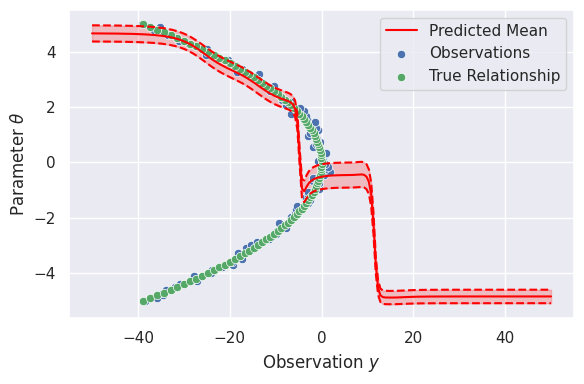

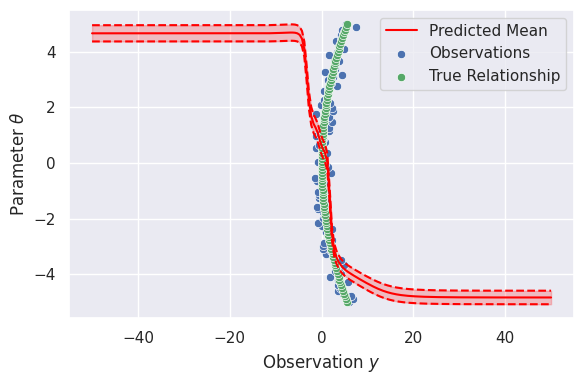

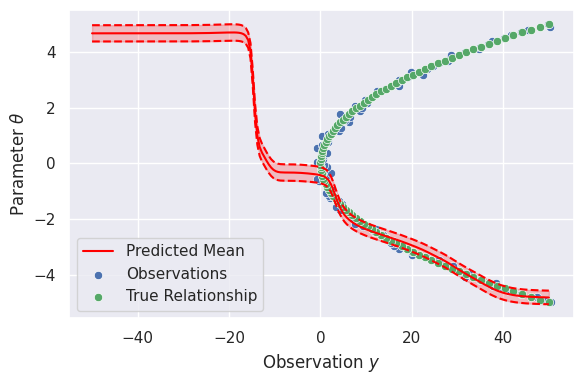

In [36]:
d_idx_to_plot= [1, 5, 10]
for d_idx in d_idx_to_plot:
    fig, ax = plt.subplots()
    plot_phi_function(reverse_approx, d_idx, d=d, y_obs=y, model=model_func)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_save_dir, f'reverse_amortised_d_idx={d_idx}.png'), dpi=mpl_save_dpi, bbox_inches='tight')

Try Forward KL divergence:

In [29]:
model, model_grad = approx_post.models.from_jax(model_func)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)
prngkey = jax.random.PRNGKey(10)
approx_dist = approx_post.distributions.approx.Gaussian(1)
preprocessing = approx_post.distributions.amortised.Preprocessing.std_scaling(y, d) #,d
phi_lims = None 
forward_approx = approx_post.distributions.amortised.NeuralNetwork(approx_dist, x_dim=1, d_dim=1, prngkey=prngkey, 
                                                                   num_layers=5, width=5, activation='tanh', 
                                                                   preprocessing=preprocessing, phi_lims=phi_lims)

In [30]:
loss = approx_post.losses.ForwardKL(joint_dist, use_reparameterisation=False)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(forward_approx, loss, x=y, d=d, prngkey=prngkey, verbose=True, num_samples=1000, max_iter=100) 

Loss = 0.0043114181607961655, Params = Jaxtainer({'W_0': DeviceArray([[ 0.60567313, -0.38894716,  1.1360339 , -0.42176178,
              -1.6181524 ],
             [ 0.5421534 , -0.23705661, -0.27421334,  0.83869797,
              -0.352473  ]], dtype=float32), 'b_0': DeviceArray([-0.09988258,  0.09994624,  0.09989101,  0.09997091,
              0.09920503], dtype=float32), 'W_1': DeviceArray([[-0.16560441, -0.562197  , -0.47582442, -0.31056982,
               0.5343513 ],
             [-0.29497096,  1.2703509 , -1.3519523 ,  0.40102518,
              -0.00756769],
             [-0.5706038 ,  0.9379423 ,  0.21806532,  0.47774443,
              -0.23291966],
             [-0.1228167 ,  0.9859233 ,  0.6705909 , -0.52911556,
              -0.8476529 ],
             [-1.1500049 ,  0.6973335 ,  0.9152067 ,  0.47091988,
               1.0499057 ]], dtype=float32), 'b_1': DeviceArray([ 0.09999681,  0.09996517,  0.09999564,  0.09999851,
             -0.0999978 ], dtype=float32), 'W_2': DeviceA

Loss = 0.002447350649163127, Params = Jaxtainer({'W_0': DeviceArray([[ 0.83176494, -0.47875723,  0.8980913 , -0.36442244,
              -1.8588656 ],
             [ 0.71824193, -0.42176038, -0.50986964,  0.8085144 ,
              -0.587103  ]], dtype=float32), 'b_0': DeviceArray([-0.01076608,  0.07065273,  0.02353708,  0.23620355,
              0.06917626], dtype=float32), 'W_1': DeviceArray([[-0.33286947, -0.7481229 , -0.21836397, -0.07454462,
               0.71506876],
             [-0.12176947,  1.3786488 , -1.6098138 ,  0.16611135,
              -0.19120483],
             [-0.7399228 ,  1.0267375 ,  0.4757942 ,  0.71731085,
              -0.05112194],
             [ 0.06285882,  0.791965  ,  0.4110437 , -0.7684408 ,
              -1.0361533 ],
             [-0.9866129 ,  0.6990632 ,  0.6582227 ,  0.23202029,
               0.8712102 ]], dtype=float32), 'b_1': DeviceArray([ 0.34812015,  0.1461693 ,  0.22791754,  0.24518846,
             -0.35158354], dtype=float32), 'W_2': DeviceAr

Loss = 0.002478570444509387, Params = Jaxtainer({'W_0': DeviceArray([[ 1.0079199 , -0.61443603,  0.72465926, -0.34451377,
              -2.0413768 ],
             [ 0.7917695 , -0.5060026 , -0.74310696,  0.82170135,
              -0.8081335 ]], dtype=float32), 'b_0': DeviceArray([ 0.1397826 ,  0.03153983, -0.20522726,  0.30407202,
             -0.1244721 ], dtype=float32), 'W_1': DeviceArray([[-0.42760947, -0.90641296, -0.05041658,  0.0803385 ,
               0.80606127],
             [-0.02119861,  1.4561923 , -1.7809408 ,  0.01051611,
              -0.28483203],
             [-0.840802  ,  1.0087885 ,  0.64767426,  0.87732035,
               0.04400354],
             [ 0.18065837,  0.6420001 ,  0.23010053, -0.93329954,
              -1.1363128 ],
             [-0.8947536 ,  0.8141745 ,  0.4918187 ,  0.07575597,
               0.78144723]], dtype=float32), 'b_1': DeviceArray([ 0.5135538 ,  0.03836004,  0.30004746,  0.330278  ,
             -0.50469804], dtype=float32), 'W_2': DeviceAr

Loss = 0.002397296717390418, Params = Jaxtainer({'W_0': DeviceArray([[ 1.147756  , -0.75336814,  0.6708919 , -0.3580972 ,
              -2.1408212 ],
             [ 0.7953518 , -0.52110827, -0.9131855 ,  0.75203955,
              -0.980118  ]], dtype=float32), 'b_0': DeviceArray([ 0.25711635, -0.01267612, -0.3728978 ,  0.36570933,
             -0.25718084], dtype=float32), 'W_1': DeviceArray([[-0.49510333, -1.0110189 ,  0.06422821,  0.18767169,
               0.86927605],
             [ 0.0500378 ,  1.5023205 , -1.8976269 , -0.09720817,
              -0.3498306 ],
             [-0.91513306,  0.98905605,  0.7685711 ,  0.9892504 ,
               0.1093542 ],
             [ 0.26394045,  0.5425436 ,  0.10376373, -1.0466248 ,
              -1.2034569 ],
             [-0.82811534,  0.8964146 ,  0.37692583, -0.03295321,
               0.7188052 ]], dtype=float32), 'b_1': DeviceArray([ 0.6246558 , -0.04642544,  0.34838238,  0.3873542 ,
             -0.6096673 ], dtype=float32), 'W_2': DeviceAr

Loss = 0.0024450751952826977, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1662328 , -0.80179423,  0.57771873, -0.30394128,
              -2.240507  ],
             [ 0.9319766 , -0.5580288 , -1.0548893 ,  0.6879449 ,
              -1.0732137 ]], dtype=float32), 'b_0': DeviceArray([ 0.2659416 , -0.01132931, -0.49774694,  0.503966  ,
             -0.37129977], dtype=float32), 'W_1': DeviceArray([[-0.54436535, -1.0784607 ,  0.14610475,  0.26401818,
               0.9102603 ],
             [ 0.10238162,  1.5318801 , -1.9809299 , -0.17390504,
              -0.39312536],
             [-0.9708437 ,  0.9858115 ,  0.85549945,  1.0692923 ,
               0.1513684 ],
             [ 0.32690766,  0.46609154,  0.01300243, -1.1278001 ,
              -1.2494185 ],
             [-0.77988756,  0.94089586,  0.29491377, -0.11015933,
               0.679366  ]], dtype=float32), 'b_1': DeviceArray([ 0.70293474, -0.09961928,  0.38400856,  0.42844892,
             -0.6914374 ], dtype=float32), 'W_2': DeviceA

Loss = 0.002360152080655098, Params = Jaxtainer({'W_0': DeviceArray([[ 1.0701134 , -0.7539684 ,  0.36584115, -0.1201392 ,
              -2.3381748 ],
             [ 1.1358335 , -0.62287104, -1.2381243 ,  0.77280277,
              -1.1229576 ]], dtype=float32), 'b_0': DeviceArray([ 0.1972517 ,  0.02336808, -0.5929246 ,  0.71401095,
             -0.4641943 ], dtype=float32), 'W_1': DeviceArray([[-0.5752161 , -1.1203662 ,  0.20524874,  0.3183342 ,
               0.9283921 ],
             [ 0.13598387,  1.5486001 , -2.041134  , -0.22855787,
              -0.41407034],
             [-1.011773  ,  1.0046403 ,  0.9202539 ,  1.1278917 ,
               0.17450015],
             [ 0.37522617,  0.3998284 , -0.05385976, -1.1875755 ,
              -1.2822671 ],
             [-0.7505074 ,  0.94782674,  0.23562166, -0.16503882,
               0.6642285 ]], dtype=float32), 'b_1': DeviceArray([ 0.7608558 , -0.12595415,  0.41235286,  0.45925763,
             -0.7617437 ], dtype=float32), 'W_2': DeviceAr

Loss = 0.0023569022305309772, Params = Jaxtainer({'W_0': DeviceArray([[ 0.94879144, -0.7108976 ,  0.32188836, -0.14754672,
              -2.3884583 ],
             [ 1.3011657 , -0.63763726, -1.4479963 ,  0.7867264 ,
              -1.1880367 ]], dtype=float32), 'b_0': DeviceArray([ 0.1438024 ,  0.00533744, -0.5792863 ,  0.7302354 ,
             -0.51374334], dtype=float32), 'W_1': DeviceArray([[-0.5991851 , -1.1564691 ,  0.24611181,  0.35679936,
               0.9532107 ],
             [ 0.16268067,  1.5648077 , -2.0834446 , -0.2673491 ,
              -0.4413851 ],
             [-1.0524623 ,  1.0281771 ,  0.9719688 ,  1.1741695 ,
               0.19965504],
             [ 0.4092233 ,  0.34353054, -0.10456753, -1.2324747 ,
              -1.2985029 ],
             [-0.7262502 ,  0.9433482 ,  0.19200985, -0.2045839 ,
               0.64220923]], dtype=float32), 'b_1': DeviceArray([ 0.795912  , -0.14326209,  0.43762523,  0.48449147,
             -0.80572176], dtype=float32), 'W_2': DeviceA

Loss = 0.0023403482045978308, Params = Jaxtainer({'W_0': DeviceArray([[ 0.80209404, -0.68536747,  0.2698093 , -0.17790715,
              -2.396542  ],
             [ 1.441388  , -0.5907815 , -1.6775533 ,  0.8281322 ,
              -1.27041   ]], dtype=float32), 'b_0': DeviceArray([ 0.10689615, -0.06704693, -0.49273056,  0.66776055,
             -0.52935773], dtype=float32), 'W_1': DeviceArray([[-0.60798734, -1.1884133 ,  0.27176496,  0.3815503 ,
               0.97864807],
             [ 0.17441459,  1.570398  , -2.1118722 , -0.29282936,
              -0.46857628],
             [-1.0862118 ,  1.0627388 ,  1.0161914 ,  1.2120105 ,
               0.21836759],
             [ 0.43448326,  0.2937979 , -0.14406596, -1.2670397 ,
              -1.3051395 ],
             [-0.7148421 ,  0.92113024,  0.16011672, -0.23134857,
               0.6194993 ]], dtype=float32), 'b_1': DeviceArray([ 0.81888944, -0.15183407,  0.46114168,  0.50562537,
             -0.8331939 ], dtype=float32), 'W_2': DeviceA

Loss = 0.002332543721422553, Params = Jaxtainer({'W_0': DeviceArray([[ 0.63044995, -0.63919723,  0.1816785 , -0.1660926 ,
              -2.3885162 ],
             [ 1.5750403 , -0.52465624, -1.921231  ,  0.91256094,
              -1.3446984 ]], dtype=float32), 'b_0': DeviceArray([ 0.08566757, -0.17039524, -0.3558659 ,  0.59331775,
             -0.5287639 ], dtype=float32), 'W_1': DeviceArray([[-0.6080864 , -1.2241925 ,  0.28654456,  0.3954082 ,
               0.9969703 ],
             [ 0.17783475,  1.5671399 , -2.130768  , -0.30843523,
              -0.48735675],
             [-1.1167322 ,  1.1070633 ,  1.0541929 ,  1.2447983 ,
               0.22985576],
             [ 0.45308685,  0.24999669, -0.17438659, -1.2925528 ,
              -1.3081651 ],
             [-0.7111145 ,  0.8812557 ,  0.13775595, -0.24864903,
               0.60458046]], dtype=float32), 'b_1': DeviceArray([ 0.83112586, -0.15166976,  0.48272246,  0.52507627,
             -0.8560107 ], dtype=float32), 'W_2': DeviceAr

Loss = 0.002260006032884121, Params = Jaxtainer({'W_0': DeviceArray([[ 0.41706565, -0.49879324,  0.11693492, -0.18349433,
              -2.3889184 ],
             [ 1.713253  , -0.50018245, -2.1352239 ,  0.91846234,
              -1.3874453 ]], dtype=float32), 'b_0': DeviceArray([ 0.07438054, -0.33166802, -0.15125456,  0.5385879 ,
             -0.53460413], dtype=float32), 'W_1': DeviceArray([[-0.6123441 , -1.2673007 ,  0.29871967,  0.40693146,
               1.0138971 ],
             [ 0.1843236 ,  1.5497712 , -2.146938  , -0.32294202,
              -0.5016788 ],
             [-1.1353233 ,  1.15773   ,  1.0802665 ,  1.2672561 ,
               0.23267835],
             [ 0.46725273,  0.21078181, -0.19483337, -1.309472  ,
              -1.3063296 ],
             [-0.7052902 ,  0.82374424,  0.12014086, -0.264898  ,
               0.5934575 ]], dtype=float32), 'b_1': DeviceArray([ 0.84097123, -0.14207363,  0.5040642 ,  0.5432634 ,
             -0.8781327 ], dtype=float32), 'W_2': DeviceAr

Loss = 0.002198808826506138, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14347553, -0.2434451 ,  0.0798176 , -0.29056087,
              -2.3976061 ],
             [ 1.859621  , -0.5699248 , -2.2923222 ,  0.77059495,
              -1.4013823 ]], dtype=float32), 'b_0': DeviceArray([ 0.05002201, -0.5924763 ,  0.07149293,  0.5155651 ,
             -0.55921614], dtype=float32), 'W_1': DeviceArray([[-0.62633646, -1.3130673 ,  0.31501493,  0.42386538,
               1.0392379 ],
             [ 0.19646832,  1.5115525 , -2.1665187 , -0.34344774,
              -0.52081275],
             [-1.1368407 ,  1.215355  ,  1.0851855 ,  1.2687944 ,
               0.21953246],
             [ 0.47964427,  0.17108099, -0.19924547, -1.3214034 ,
              -1.2958617 ],
             [-0.6928717 ,  0.7472561 ,  0.11033419, -0.2815187 ,
               0.5766864 ]], dtype=float32), 'b_1': DeviceArray([ 0.85829526, -0.12604788,  0.53159666,  0.5549538 ,
             -0.8931005 ], dtype=float32), 'W_2': DeviceAr

Loss = 0.002251103986054659, Params = Jaxtainer({'W_0': DeviceArray([[ 0.0580668 , -0.22552317,  0.15605702, -0.35544974,
              -2.4144757 ],
             [ 2.0088105 , -0.6985444 , -2.3219056 ,  0.6449979 ,
              -1.3905097 ]], dtype=float32), 'b_0': DeviceArray([-0.08355501, -0.64585966,  0.12593827,  0.52349824,
             -0.60207057], dtype=float32), 'W_1': DeviceArray([[-0.59804785, -1.3670691 ,  0.3693608 ,  0.4834871 ,
               1.0617522 ],
             [ 0.16178928,  1.4669986 , -2.2204142 , -0.40255675,
              -0.53385   ],
             [-1.1734004 ,  1.2763951 ,  1.0422779 ,  1.2182082 ,
               0.20288712],
             [ 0.44438857,  0.14767186, -0.24246685, -1.3763632 ,
              -1.2809316 ],
             [-0.7262522 ,  0.6913027 ,  0.0622506 , -0.34093076,
               0.5643571 ]], dtype=float32), 'b_1': DeviceArray([ 0.84371734, -0.0975676 ,  0.5153693 ,  0.52719015,
             -0.9097001 ], dtype=float32), 'W_2': DeviceAr

Loss = 0.0022195966448634863, Params = Jaxtainer({'W_0': DeviceArray([[-0.04380831, -0.21310781,  0.25241643, -0.2986571 ,
              -2.4282815 ],
             [ 2.0236673 , -0.6130339 , -2.346472  ,  0.7506508 ,
              -1.3688445 ]], dtype=float32), 'b_0': DeviceArray([-0.10770434, -0.7749072 ,  0.20366621,  0.38250285,
             -0.6553973 ], dtype=float32), 'W_1': DeviceArray([[-0.5639056 , -1.3683451 ,  0.38294637,  0.51120603,
               1.0680685 ],
             [ 0.12555103,  1.4325504 , -2.2522511 , -0.44670317,
              -0.53063864],
             [-1.2186667 ,  1.3100141 ,  1.0308326 ,  1.1943918 ,
               0.19787532],
             [ 0.408801  ,  0.10689413, -0.2590525 , -1.4103189 ,
              -1.2658932 ],
             [-0.7668346 ,  0.60138583,  0.05911158, -0.36393404,
               0.57031924]], dtype=float32), 'b_1': DeviceArray([ 0.82370883, -0.09808163,  0.5325035 ,  0.5260029 ,
             -0.930258  ], dtype=float32), 'W_2': DeviceA

Loss = 0.002247595228254795, Params = Jaxtainer({'W_0': DeviceArray([[ 0.03279173, -0.20120436,  0.31540325, -0.23781312,
              -2.4371352 ],
             [ 2.066313  , -0.5134683 , -2.375826  ,  0.8617914 ,
              -1.3477137 ]], dtype=float32), 'b_0': DeviceArray([-0.07461482, -0.89187866,  0.3020133 ,  0.2035742 ,
             -0.7049129 ], dtype=float32), 'W_1': DeviceArray([[-0.5369105 , -1.397683  ,  0.3812146 ,  0.5228231 ,
               1.0718441 ],
             [ 0.09886117,  1.4912424 , -2.2696412 , -0.47549456,
              -0.5307545 ],
             [-1.2574234 ,  1.2541617 ,  1.033353  ,  1.1852762 ,
               0.1964922 ],
             [ 0.38285512,  0.14587483, -0.26356363, -1.4280903 ,
              -1.2508109 ],
             [-0.79871076,  0.6387117 ,  0.07007232, -0.37026516,
               0.5717759 ]], dtype=float32), 'b_1': DeviceArray([ 0.80507433, -0.06776628,  0.55771494,  0.5362676 ,
             -0.94414693], dtype=float32), 'W_2': DeviceAr

Loss = 0.00215682340785861, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13316979, -0.221111  ,  0.35507753, -0.2184073 ,
              -2.4434786 ],
             [ 2.115916  , -0.4729266 , -2.3949692 ,  0.893103  ,
              -1.3285766 ]], dtype=float32), 'b_0': DeviceArray([-0.16099116, -0.9448305 ,  0.3690202 ,  0.08593255,
             -0.74757975], dtype=float32), 'W_1': DeviceArray([[-0.51831704, -1.4579158 ,  0.3840695 ,  0.53749186,
               1.0776136 ],
             [ 0.07763238,  1.5486482 , -2.284702  , -0.50040907,
              -0.53085953],
             [-1.2841141 ,  1.1760465 ,  1.0309017 ,  1.1721457 ,
               0.18508801],
             [ 0.3633293 ,  0.22907549, -0.2686622 , -1.4417368 ,
              -1.2322526 ],
             [-0.82247186,  0.74581677,  0.07284744, -0.38145202,
               0.57168466]], dtype=float32), 'b_1': DeviceArray([ 0.79339355,  0.00199831,  0.5721225 ,  0.5426878 ,
             -0.95611143], dtype=float32), 'W_2': DeviceArr

Loss = 0.002138383686542511, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15577447, -0.20971708,  0.36154038, -0.17088577,
              -2.4492881 ],
             [ 2.1078486 , -0.43140048, -2.4404898 ,  0.91929895,
              -1.3096198 ]], dtype=float32), 'b_0': DeviceArray([-0.2906921 , -1.0132914 ,  0.44394124, -0.01571784,
             -0.7858641 ], dtype=float32), 'W_1': DeviceArray([[-0.504064  , -1.4704463 ,  0.37868398,  0.5447908 ,
               1.0807103 ],
             [ 0.05954375,  1.5915595 , -2.2954795 , -0.5195744 ,
              -0.524461  ],
             [-1.3045688 ,  1.1234055 ,  1.0284039 ,  1.1621292 ,
               0.16492414],
             [ 0.34932733,  0.28198072, -0.26661515, -1.4475381 ,
              -1.2134237 ],
             [-0.84361285,  0.7956585 ,  0.08385299, -0.38474423,
               0.5790182 ]], dtype=float32), 'b_1': DeviceArray([ 0.7860436 ,  0.04291052,  0.59117824,  0.55441767,
             -0.97035944], dtype=float32), 'W_2': DeviceAr

Loss = 0.002137682633474469, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12741606, -0.22126926,  0.37379357, -0.20781176,
              -2.453976  ],
             [ 2.0767207 , -0.44675007, -2.4387476 ,  0.8468159 ,
              -1.2920265 ]], dtype=float32), 'b_0': DeviceArray([-0.46972948, -1.0453871 ,  0.47668657, -0.07028218,
             -0.81898785], dtype=float32), 'W_1': DeviceArray([[-0.4931992 , -1.4695098 ,  0.38379994,  0.55947226,
               1.0920436 ],
             [ 0.04004259,  1.6052234 , -2.311152  , -0.53881234,
              -0.5224131 ],
             [-1.3123572 ,  1.0963722 ,  1.013463  ,  1.1465666 ,
               0.12324197],
             [ 0.3359467 ,  0.31633353, -0.2596464 , -1.4490067 ,
              -1.1878523 ],
             [-0.8618033 ,  0.81982857,  0.0837912 , -0.3961607 ,
               0.58053046]], dtype=float32), 'b_1': DeviceArray([ 0.7888851 ,  0.07599282,  0.5986147 ,  0.56148845,
             -0.981553  ], dtype=float32), 'W_2': DeviceAr

Loss = 0.0021212659776210785, Params = Jaxtainer({'W_0': DeviceArray([[ 0.11551369, -0.25292405,  0.39340043, -0.3021487 ,
              -2.4577467 ],
             [ 2.062413  , -0.5017464 , -2.4071155 ,  0.72001207,
              -1.2766783 ]], dtype=float32), 'b_0': DeviceArray([-0.5971575 , -1.0468261 ,  0.4708024 , -0.12427736,
             -0.84649485], dtype=float32), 'W_1': DeviceArray([[-0.48948792, -1.4686259 ,  0.39520106,  0.5790515 ,
               1.1131936 ],
             [ 0.0259548 ,  1.6150306 , -2.3272855 , -0.55612373,
              -0.5327738 ],
             [-1.3173823 ,  1.0786724 ,  0.99264145,  1.1283054 ,
               0.07949018],
             [ 0.3274128 ,  0.3413879 , -0.25079337, -1.448654  ,
              -1.1642013 ],
             [-0.8708293 ,  0.8374833 ,  0.07667592, -0.4133353 ,
               0.5682942 ]], dtype=float32), 'b_1': DeviceArray([ 0.7939549 ,  0.09988029,  0.5983652 ,  0.56455964,
             -0.9832919 ], dtype=float32), 'W_2': DeviceA

Loss = 0.0021141425240784883, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13598366, -0.26375222,  0.39299822, -0.34096467,
              -2.460683  ],
             [ 2.0321648 , -0.5323704 , -2.41124   ,  0.6652053 ,
              -1.2635807 ]], dtype=float32), 'b_0': DeviceArray([-0.6518866 , -1.0617962 ,  0.46097   , -0.13118474,
             -0.86933374], dtype=float32), 'W_1': DeviceArray([[-0.4887975 , -1.4590694 ,  0.3977255 ,  0.59188306,
               1.1153678 ],
             [ 0.01795466,  1.6395447 , -2.33741   , -0.56718296,
              -0.5297003 ],
             [-1.3255384 ,  1.0603067 ,  0.97851396,  1.1153165 ,
               0.06129625],
             [ 0.32429355,  0.36131135, -0.24072176, -1.4471006 ,
              -1.143516  ],
             [-0.874267  ,  0.8493291 ,  0.07762595, -0.4241371 ,
               0.5700071 ]], dtype=float32), 'b_1': DeviceArray([ 0.79670537,  0.10959765,  0.603797  ,  0.5680999 ,
             -0.9917656 ], dtype=float32), 'W_2': DeviceA

Loss = 0.002110061701387167, Params = Jaxtainer({'W_0': DeviceArray([[ 0.22899541, -0.26567116,  0.38102195, -0.35582945,
              -2.4631655 ],
             [ 2.039719  , -0.55297256, -2.4361954 ,  0.657402  ,
              -1.2527758 ]], dtype=float32), 'b_0': DeviceArray([-0.565372  , -1.0770608 ,  0.43323746, -0.10593878,
             -0.8876208 ], dtype=float32), 'W_1': DeviceArray([[-0.49124706, -1.4527078 ,  0.39506802,  0.6024503 ,
               1.1043588 ],
             [ 0.01595429,  1.6816257 , -2.34238   , -0.57214034,
              -0.5237961 ],
             [-1.3373522 ,  1.0390522 ,  0.96862394,  1.1052101 ,
               0.06917632],
             [ 0.32683071,  0.38120505, -0.23016377, -1.4461788 ,
              -1.1294605 ],
             [-0.87000066,  0.86773527,  0.08301317, -0.43332338,
               0.57371426]], dtype=float32), 'b_1': DeviceArray([ 0.79730904,  0.108613  ,  0.6120315 ,  0.569127  ,
             -1.0003633 ], dtype=float32), 'W_2': DeviceAr

Loss = 0.0021017584949731827, Params = Jaxtainer({'W_0': DeviceArray([[ 0.31635088, -0.26043776,  0.36066407, -0.3717363 ,
              -2.4661744 ],
             [ 2.0782795 , -0.56127435, -2.4666126 ,  0.6538513 ,
              -1.2434989 ]], dtype=float32), 'b_0': DeviceArray([-0.440442  , -1.0886855 ,  0.37900576, -0.08410352,
             -0.90169865], dtype=float32), 'W_1': DeviceArray([[-0.49526358, -1.4529945 ,  0.3864749 ,  0.6146003 ,
               1.0957272 ],
             [ 0.01335631,  1.7150522 , -2.3408418 , -0.5712524 ,
              -0.5230565 ],
             [-1.3453834 ,  1.0251204 ,  0.96347934,  1.0952814 ,
               0.07631848],
             [ 0.32959834,  0.39753285, -0.21908665, -1.4471339 ,
              -1.1187868 ],
             [-0.8631091 ,  0.8900069 ,  0.09354778, -0.4449018 ,
               0.5705843 ]], dtype=float32), 'b_1': DeviceArray([ 0.8010911 ,  0.1069879 ,  0.62396604,  0.56686366,
             -1.0042082 ], dtype=float32), 'W_2': DeviceA

Loss = 0.0020945584401488304, Params = Jaxtainer({'W_0': DeviceArray([[ 0.36787897, -0.23219845,  0.3328662 , -0.37770998,
              -2.469755  ],
             [ 2.1141477 , -0.5171463 , -2.492605  ,  0.67024714,
              -1.2349684 ]], dtype=float32), 'b_0': DeviceArray([-0.350474  , -1.1206093 ,  0.32122162, -0.07280745,
             -0.91300416], dtype=float32), 'W_1': DeviceArray([[-0.49616206, -1.4504488 ,  0.36491147,  0.6238129 ,
               1.0920763 ],
             [ 0.00551309,  1.7333338 , -2.331167  , -0.5648182 ,
              -0.52525735],
             [-1.3434782 ,  1.0206243 ,  0.9691387 ,  1.0883286 ,
               0.07163616],
             [ 0.32774815,  0.40673152, -0.20574845, -1.4486631 ,
              -1.1127994 ],
             [-0.86067975,  0.90636915,  0.11617588, -0.45407352,
               0.5641256 ]], dtype=float32), 'b_1': DeviceArray([ 0.8105811 ,  0.10563236,  0.6457617 ,  0.56490964,
             -1.0050145 ], dtype=float32), 'W_2': DeviceA

Loss = 0.0020925658755004406, Params = Jaxtainer({'W_0': DeviceArray([[ 0.3862482 , -0.18249446,  0.30411002, -0.37381166,
              -2.4733293 ],
             [ 2.1315093 , -0.43440104, -2.5046792 ,  0.7011856 ,
              -1.2263263 ]], dtype=float32), 'b_0': DeviceArray([-0.31620032, -1.170494  ,  0.27151114, -0.03630622,
             -0.92382663], dtype=float32), 'W_1': DeviceArray([[-0.49262497, -1.4350586 ,  0.3350449 ,  0.63021207,
               1.0897    ],
             [-0.00771325,  1.7427227 , -2.3178632 , -0.555622  ,
              -0.52567434],
             [-1.3308947 ,  1.0246345 ,  0.98244613,  1.0830586 ,
               0.05763026],
             [ 0.32082155,  0.40600374, -0.18891133, -1.4496919 ,
              -1.1125551 ],
             [-0.8644159 ,  0.90770584,  0.14646351, -0.46060777,
               0.56016165]], dtype=float32), 'b_1': DeviceArray([ 0.82508135,  0.10177326,  0.67361736,  0.5627811 ,
             -1.0066434 ], dtype=float32), 'W_2': DeviceA

Loss = 0.0020839571952819824, Params = Jaxtainer({'W_0': DeviceArray([[ 0.38215658, -0.13820177,  0.28246012, -0.38207594,
              -2.477169  ],
             [ 2.13641   , -0.36425787, -2.4935515 ,  0.71040463,
              -1.2169001 ]], dtype=float32), 'b_0': DeviceArray([-0.32711574, -1.2029065 ,  0.209959  ,  0.06252351,
             -0.93491507], dtype=float32), 'W_1': DeviceArray([[-0.48483858, -1.4201896 ,  0.30835527,  0.6420247 ,
               1.0871123 ],
             [-0.02711868,  1.7432036 , -2.3037992 , -0.54445744,
              -0.52247936],
             [-1.3078946 ,  1.034898  ,  0.9979633 ,  1.0723085 ,
               0.03522902],
             [ 0.30902803,  0.40027684, -0.17206505, -1.4531859 ,
              -1.115326  ],
             [-0.8736016 ,  0.9008322 ,  0.17333329, -0.47258547,
               0.5594794 ]], dtype=float32), 'b_1': DeviceArray([ 0.8451985 ,  0.10025857,  0.6979946 ,  0.5548103 ,
             -1.0110955 ], dtype=float32), 'W_2': DeviceA

Loss = 0.002073372481390834, Params = Jaxtainer({'W_0': DeviceArray([[ 0.36316928, -0.08888367,  0.2595309 , -0.39538133,
              -2.482667  ],
             [ 2.1367385 , -0.28080836, -2.4823318 ,  0.694091  ,
              -1.2042742 ]], dtype=float32), 'b_0': DeviceArray([-0.33679566, -1.2305961 ,  0.15904899,  0.17102751,
             -0.94673055], dtype=float32), 'W_1': DeviceArray([[-0.47643316, -1.3893311 ,  0.2841385 ,  0.6530952 ,
               1.0838877 ],
             [-0.0463763 ,  1.7845055 , -2.2887862 , -0.53506094,
              -0.5189732 ],
             [-1.2832488 ,  1.0061051 ,  1.0188134 ,  1.059528  ,
               0.01197221],
             [ 0.29664472,  0.3997539 , -0.155144  , -1.4543146 ,
              -1.1174654 ],
             [-0.88391817,  0.8796704 ,  0.19753589, -0.48358476,
               0.5604721 ]], dtype=float32), 'b_1': DeviceArray([ 0.8651308 ,  0.0913582 ,  0.7198122 ,  0.54717547,
             -1.0156351 ], dtype=float32), 'W_2': DeviceAr

Loss = 0.0020679926965385675, Params = Jaxtainer({'W_0': DeviceArray([[ 0.33952343, -0.06828661,  0.21957117, -0.4054471 ,
              -2.4894834 ],
             [ 2.1437416 , -0.19159073, -2.4913225 ,  0.6560846 ,
              -1.1859639 ]], dtype=float32), 'b_0': DeviceArray([-0.29196867, -1.238048  ,  0.1518885 ,  0.23419385,
             -0.9599168 ], dtype=float32), 'W_1': DeviceArray([[-0.47041282, -1.5307031 ,  0.26718247,  0.65701675,
               1.0801355 ],
             [-0.05932344,  1.7257552 , -2.2730906 , -0.5318879 ,
              -0.5187923 ],
             [-1.2644832 ,  0.8190565 ,  1.0441617 ,  1.0499778 ,
              -0.00324539],
             [ 0.28678697,  0.515132  , -0.14352995, -1.4480114 ,
              -1.1149286 ],
             [-0.8918242 ,  0.96037745,  0.2145226 , -0.48710197,
               0.560513  ]], dtype=float32), 'b_1': DeviceArray([ 0.87906414,  0.14572282,  0.7354244 ,  0.5464071 ,
             -1.0172269 ], dtype=float32), 'W_2': DeviceA

Loss = 0.002062471816316247, Params = Jaxtainer({'W_0': DeviceArray([[ 0.31295976, -0.07836212,  0.19421805, -0.4055485 ,
              -2.4959447 ],
             [ 2.1586084 , -0.12660295, -2.4938848 ,  0.61365175,
              -1.1629293 ]], dtype=float32), 'b_0': DeviceArray([-0.18153238, -1.2327825 ,  0.1780309 ,  0.26175404,
             -0.9739863 ], dtype=float32), 'W_1': DeviceArray([[-4.7045910e-01, -1.6380142e+00,  2.5858104e-01,
               6.5886420e-01,  1.0713834e+00],
             [-6.3009858e-02,  1.7202682e+00, -2.2585595e+00,
              -5.3331310e-01, -5.1875550e-01],
             [-1.2544214e+00,  6.1674839e-01,  1.0681636e+00,
               1.0398253e+00, -7.5981650e-04],
             [ 2.8321227e-01,  6.1989599e-01, -1.3868564e-01,
              -1.4396795e+00, -1.1059649e+00],
             [-8.9366072e-01,  1.0115830e+00,  2.2329862e-01,
              -4.8819122e-01,  5.6326330e-01]], dtype=float32), 'b_1': DeviceArray([ 0.8851837 ,  0.18178356,  0.744213

Loss = 0.0020580317359417677, Params = Jaxtainer({'W_0': DeviceArray([[ 0.27654177, -0.07928543,  0.19886246, -0.3845532 ,
              -2.4917984 ],
             [ 2.164465  , -0.06717991, -2.4750357 ,  0.59879494,
              -1.1419231 ]], dtype=float32), 'b_0': DeviceArray([-0.0338891 , -1.2270489 ,  0.22909848,  0.27892488,
             -0.9919915 ], dtype=float32), 'W_1': DeviceArray([[-0.47756103, -1.6770276 ,  0.2526982 ,  0.65898913,
               1.0529269 ],
             [-0.05925234,  1.7833759 , -2.2446482 , -0.53703266,
              -0.5132559 ],
             [-1.2501838 ,  0.44868124,  1.0888765 ,  1.030703  ,
               0.02311409],
             [ 0.28633642,  0.672651  , -0.13572933, -1.4329866 ,
              -1.0944109 ],
             [-0.88893396,  0.99255687,  0.2293113 , -0.48723194,
               0.5754525 ]], dtype=float32), 'b_1': DeviceArray([ 0.8858435 ,  0.18511786,  0.7506849 ,  0.5518149 ,
             -1.0227726 ], dtype=float32), 'W_2': DeviceA

Loss = 0.0020556265953928232, Params = Jaxtainer({'W_0': DeviceArray([[ 0.23348519, -0.05861371,  0.20500992, -0.36455968,
              -2.4695985 ],
             [ 2.1715097 , -0.01047764, -2.4542649 ,  0.5860065 ,
              -1.1391007 ]], dtype=float32), 'b_0': DeviceArray([ 0.13907613, -1.2251301 ,  0.28944102,  0.2707077 ,
             -1.0105197 ], dtype=float32), 'W_1': DeviceArray([[-0.48376814, -1.7087393 ,  0.24720065,  0.6585676 ,
               1.0383995 ],
             [-0.05732751,  1.8532032 , -2.231106  , -0.54114336,
              -0.5111109 ],
             [-1.2430482 ,  0.3398059 ,  1.1063896 ,  1.0229814 ,
               0.04460469],
             [ 0.2870764 ,  0.6714288 , -0.13280225, -1.4282584 ,
              -1.0858703 ],
             [-0.88617057,  0.91340846,  0.23481898, -0.48572612,
               0.58487433]], dtype=float32), 'b_1': DeviceArray([ 0.8877646 ,  0.17898835,  0.756349  ,  0.55452317,
             -1.0247608 ], dtype=float32), 'W_2': DeviceA

Loss = 0.0020572191569954157, Params = Jaxtainer({'W_0': DeviceArray([[ 0.20441645, -0.03862374,  0.19955674, -0.3641699 ,
              -2.4424884 ],
             [ 2.224785  ,  0.03209287, -2.4419172 ,  0.5540897 ,
              -1.1665334 ]], dtype=float32), 'b_0': DeviceArray([ 0.23573439, -1.2173618 ,  0.345122  ,  0.25075313,
             -1.0189797 ], dtype=float32), 'W_1': DeviceArray([[-0.48267817, -1.8404549 ,  0.24378668,  0.6544541 ,
               1.0372738 ],
             [-0.06238065,  1.733736  , -2.218681  , -0.5455088 ,
              -0.5157222 ],
             [-1.228507  ,  0.35808107,  1.120894  ,  1.0202847 ,
               0.04656984],
             [ 0.2786866 ,  0.6538972 , -0.13191183, -1.4226806 ,
              -1.0842106 ],
             [-0.8925255 ,  0.86982983,  0.23817688, -0.48235205,
               0.5820756 ]], dtype=float32), 'b_1': DeviceArray([ 0.89412016,  0.24046822,  0.7594273 ,  0.5575703 ,
             -1.0216578 ], dtype=float32), 'W_2': DeviceA

Loss = 0.002053065923973918, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1879442 , -0.04522181,  0.20429724, -0.36390272,
              -2.4180515 ],
             [ 2.3044994 ,  0.06440775, -2.4227216 ,  0.53835195,
              -1.2019705 ]], dtype=float32), 'b_0': DeviceArray([ 0.23009473, -1.1993843 ,  0.389602  ,  0.23623212,
             -1.0357805 ], dtype=float32), 'W_1': DeviceArray([[-0.47932953, -2.0107367 ,  0.2440207 ,  0.64271533,
               1.0347767 ],
             [-0.06949452,  1.5065849 , -2.2067568 , -0.55190325,
              -0.51797724],
             [-1.2127188 ,  0.43875417,  1.1339189 ,  1.0264162 ,
               0.04732911],
             [ 0.2673536 ,  0.65018505, -0.13487794, -1.4153552 ,
              -1.0870169 ],
             [-0.90162283,  0.89585257,  0.23787971, -0.47361696,
               0.57867026]], dtype=float32), 'b_1': DeviceArray([ 0.90147835,  0.34667802,  0.75864494,  0.56219375,
             -1.0203971 ], dtype=float32), 'W_2': DeviceAr

Loss = 0.002057914389297366, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15970804, -0.05185827,  0.21150358, -0.36489716,
              -2.4136426 ],
             [ 2.3574994 ,  0.09184379, -2.4007995 ,  0.5213455 ,
              -1.2201388 ]], dtype=float32), 'b_0': DeviceArray([ 0.2613025 , -1.1842809 ,  0.43790343,  0.22669898,
             -1.0729394 ], dtype=float32), 'W_1': DeviceArray([[-0.47933683, -2.1291494 ,  0.2447992 ,  0.633331  ,
               1.0301924 ],
             [-0.07008893,  1.3907118 , -2.1968029 , -0.5564126 ,
              -0.52039504],
             [-1.2041128 ,  0.4768843 ,  1.1438509 ,  1.0299138 ,
               0.05764533],
             [ 0.25991377,  0.6539921 , -0.13812493, -1.4097598 ,
              -1.0917495 ],
             [-0.90685886,  0.9805645 ,  0.23700051, -0.46715146,
               0.5749288 ]], dtype=float32), 'b_1': DeviceArray([ 0.9033912,  0.4041866,  0.7574713,  0.5647048, -1.019302 ],            dtype=float32), 'W_2': DeviceArray([[-

Loss = 0.0020527811720967293, Params = Jaxtainer({'W_0': DeviceArray([[ 0.11468384, -0.04060638,  0.20434442, -0.35733387,
              -2.4210358 ],
             [ 2.359938  ,  0.12973288, -2.3959794 ,  0.52081853,
              -1.2190552 ]], dtype=float32), 'b_0': DeviceArray([ 0.31400946, -1.1714396 ,  0.48537114,  0.2555435 ,
             -1.1397321 ], dtype=float32), 'W_1': DeviceArray([[-0.48153967, -2.174883  ,  0.24425025,  0.6245334 ,
               1.0098513 ],
             [-0.06564219,  1.3976697 , -2.1890156 , -0.5581991 ,
              -0.5110645 ],
             [-1.2024959 ,  0.44985875,  1.150929  ,  1.0320196 ,
               0.08332521],
             [ 0.25540936,  0.67027   , -0.14016588, -1.4059427 ,
              -1.0930923 ],
             [-0.90961933,  1.1182253 ,  0.23734051, -0.46135855,
               0.5842162 ]], dtype=float32), 'b_1': DeviceArray([ 0.9011122 ,  0.40800887,  0.75726235,  0.56464964,
             -1.0275466 ], dtype=float32), 'W_2': DeviceA

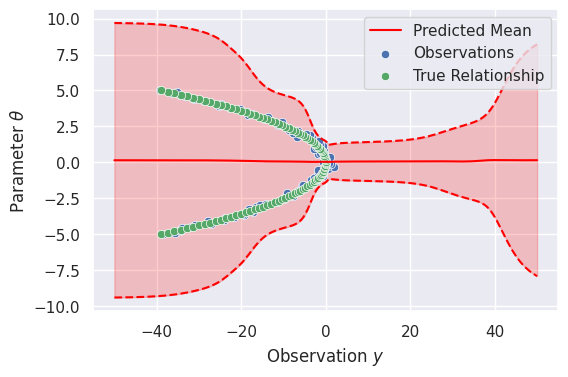

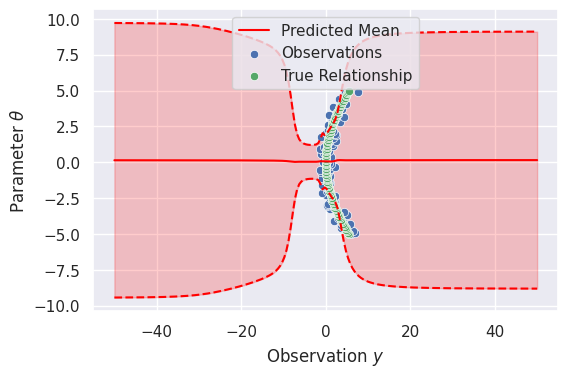

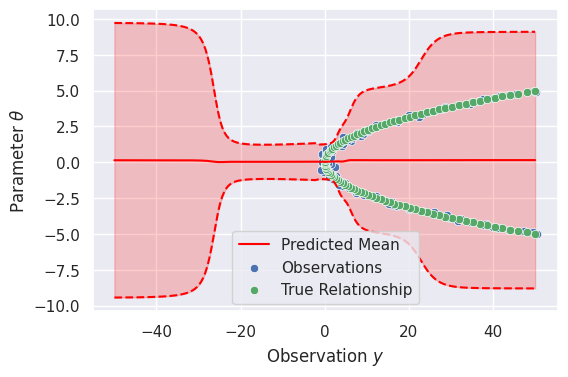

In [37]:
d_idx_to_plot= [1, 5, 10]
for d_idx in d_idx_to_plot:
    fig, ax = plt.subplots()
    plot_phi_function(forward_approx, d_idx, d=d, y_obs=y, model=model_func)
    plt.savefig(os.path.join(fig_save_dir, f'forward_amortised_d_idx={d_idx}.png'), dpi=mpl_save_dpi, bbox_inches='tight')